In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
import keras
from PIL import Image, ImageOps

In [2]:
os.getcwd()

'/mnt/d/Denver/final_quarter/capstone/DogBreedClassification'

In [3]:
train_path = 'data/train'
path_to_pic = 'data/train/'
image_name = os.listdir(path_to_pic)[6]

In [4]:
%%time
reconstructed_model = tf.keras.models.load_model("data/new_model", compile = False)

CPU times: user 31.3 s, sys: 2.8 s, total: 34.1 s
Wall time: 33.8 s


In [5]:
reconstructed_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               483960    
Total params: 85,400,778
Trainable params: 483,960
Non-trainable params: 84,916,818
_________________________________________________________________


In [6]:
train_datagen=ImageDataGenerator(rescale=1./255.,
                                      horizontal_flip = True,
                                      validation_split=0.02 
                                  )
train_df = pd.read_csv('data/preprocessed_saves/our_train.csv')
img_size = (331, 331)
test_df = pd.DataFrame({'id': [image_name], 'breed': ['unknown']})
all_breeds = pd.read_csv('data/labels.csv').sort_values(by = "breed").filter(['breed']).drop_duplicates().reset_index(drop = True)
train_generator=train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_path,
    x_col = "id",
    y_col = "breed",
    subset = "training",
    seed = 13,
    shuffle = True,
    class_mode = "categorical",
    target_size = img_size,
    color_mode = "rgb" 
)

valid_generator=train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_path,
    x_col = "id",
    y_col = "breed",
    subset = "validation",
    seed = 13,
    shuffle = True,
    class_mode="categorical",
    target_size = img_size,
    color_mode = "rgb"
)

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = path_to_pic,
    x_col="id",
    y_col = None,
    seed = 14,
    shuffle = False,
    class_mode = None,
    target_size = img_size,
    color_mode="rgb"
)

Found 8015 validated image filenames belonging to 120 classes.
Found 163 validated image filenames belonging to 120 classes.
Found 1 validated image filenames.


In [7]:
shape = (331, 331, 3)

In [8]:
%%time
pred = reconstructed_model.predict(test_generator)

CPU times: user 4.11 s, sys: 234 ms, total: 4.34 s
Wall time: 3.39 s


In [9]:
predicted_df = pd.DataFrame(pred, columns = all_breeds.breed)
final_preds = predicted_df.idxmax(axis = 1)
to_display = (predicted_df.reset_index().set_index(['index'])
   .rename_axis(['breed'], axis=1)
   .stack()
   .unstack('index')
   .reset_index()
   .filter(['breed', 0])
   .sort_values(by = 0, ascending = False)
   .rename(columns = {0 : 'probability'})
   .head())
   
to_display.breed.values[[0]][0]



'bedlington_terrier'

In [10]:
to_display

index,breed,probability
10,bedlington_terrier,0.874837
118,wire-haired_fox_terrier,0.003031
93,saluki,0.002837
58,irish_water_spaniel,0.002289
76,miniature_poodle,0.002263


In [11]:
print("That looks like a %s!" % to_display.breed.values[[0]][0])

That looks like a bedlington_terrier!


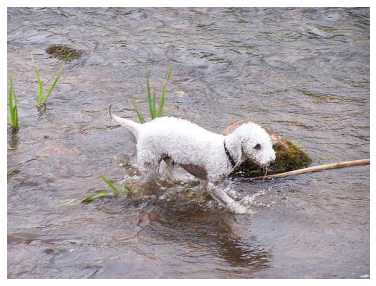

In [12]:
fig = plt.figure(figsize = (10,5))
for i in range(1):
    plt.subplot(1, 1, i+1)
    img = plt.imread(os.path.join(path_to_pic, image_name))
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.axis('off')

In [13]:
to_display.style.hide_index()

breed,probability
bedlington_terrier,0.874837
wire-haired_fox_terrier,0.003031
saluki,0.002837
irish_water_spaniel,0.002289
miniature_poodle,0.002263
